In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
num_epochs = 50
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-4
mixup_alpha = 0.4
num_classes = 10
class_names = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

In [5]:
# ### 3. Data Augmentation & Loaders
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


100%|██████████| 170M/170M [00:10<00:00, 16.1MB/s]


In [6]:
# ### 4. MixUp Function

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [7]:
# ### 5. Model: Pretrained ResNet-18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


In [8]:
# ### 6. Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

In [9]:
# ### 7. Training Loop
train_losses, train_accs, test_accs = [], [], []
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)
      ## Apply MixUP
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, mixup_alpha)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss); train_accs.append(epoch_acc)
    scheduler.step()

    # Validation
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()
    test_acc = 100. * correct_test / total_test
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}: Loss {epoch_loss:.4f}, Train Acc {epoch_acc:.2f}%, Test Acc {test_acc:.2f}%")


Epoch 1/50: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s]


Epoch 1: Loss 1.4778, Train Acc 52.66%, Test Acc 70.05%


Epoch 2/50: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Epoch 2: Loss 1.2842, Train Acc 60.49%, Test Acc 75.36%


Epoch 3/50: 100%|██████████| 391/391 [00:25<00:00, 15.49it/s]


Epoch 3: Loss 1.2219, Train Acc 62.58%, Test Acc 76.47%


Epoch 4/50: 100%|██████████| 391/391 [00:25<00:00, 15.44it/s]


Epoch 4: Loss 1.1421, Train Acc 65.37%, Test Acc 76.24%


Epoch 5/50: 100%|██████████| 391/391 [00:25<00:00, 15.48it/s]


Epoch 5: Loss 1.1498, Train Acc 65.11%, Test Acc 79.84%


Epoch 6/50: 100%|██████████| 391/391 [00:25<00:00, 15.46it/s]


Epoch 6: Loss 1.0755, Train Acc 67.87%, Test Acc 77.50%


Epoch 7/50: 100%|██████████| 391/391 [00:25<00:00, 15.48it/s]


Epoch 7: Loss 1.1000, Train Acc 67.19%, Test Acc 80.64%


Epoch 8/50: 100%|██████████| 391/391 [00:25<00:00, 15.43it/s]


Epoch 8: Loss 1.0573, Train Acc 68.38%, Test Acc 80.95%


Epoch 9/50: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s]


Epoch 9: Loss 1.0367, Train Acc 68.66%, Test Acc 80.09%


Epoch 10/50: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Epoch 10: Loss 1.0216, Train Acc 69.81%, Test Acc 81.55%


Epoch 11/50: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s]


Epoch 11: Loss 1.0019, Train Acc 70.01%, Test Acc 82.58%


Epoch 12/50: 100%|██████████| 391/391 [00:25<00:00, 15.49it/s]


Epoch 12: Loss 0.9962, Train Acc 70.42%, Test Acc 82.34%


Epoch 13/50: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Epoch 13: Loss 0.9392, Train Acc 71.98%, Test Acc 81.94%


Epoch 14/50: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]


Epoch 14: Loss 0.9636, Train Acc 71.50%, Test Acc 82.62%


Epoch 15/50: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s]


Epoch 15: Loss 0.9637, Train Acc 71.35%, Test Acc 83.93%


Epoch 16/50: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s]


Epoch 16: Loss 0.9709, Train Acc 71.30%, Test Acc 83.52%


Epoch 17/50: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Epoch 17: Loss 0.9476, Train Acc 71.73%, Test Acc 84.91%


Epoch 18/50: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Epoch 18: Loss 0.9108, Train Acc 73.19%, Test Acc 84.60%


Epoch 19/50: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Epoch 19: Loss 0.8978, Train Acc 73.72%, Test Acc 84.62%


Epoch 20/50: 100%|██████████| 391/391 [00:25<00:00, 15.44it/s]


Epoch 20: Loss 0.8954, Train Acc 74.08%, Test Acc 84.50%


Epoch 21/50: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s]


Epoch 21: Loss 0.8934, Train Acc 73.81%, Test Acc 85.07%


Epoch 22/50: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]


Epoch 22: Loss 0.9767, Train Acc 70.95%, Test Acc 83.28%


Epoch 23/50: 100%|██████████| 391/391 [00:25<00:00, 15.48it/s]


Epoch 23: Loss 0.9138, Train Acc 73.09%, Test Acc 84.72%


Epoch 24/50: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Epoch 24: Loss 0.9055, Train Acc 73.13%, Test Acc 85.77%


Epoch 25/50: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]


Epoch 25: Loss 0.8673, Train Acc 74.89%, Test Acc 85.77%


Epoch 26/50: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Epoch 26: Loss 0.8717, Train Acc 74.53%, Test Acc 86.39%


Epoch 27/50: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s]


Epoch 27: Loss 0.8519, Train Acc 75.43%, Test Acc 85.33%


Epoch 28/50: 100%|██████████| 391/391 [00:25<00:00, 15.48it/s]


Epoch 28: Loss 0.8079, Train Acc 76.76%, Test Acc 86.43%


Epoch 29/50: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s]


Epoch 29: Loss 0.8237, Train Acc 76.77%, Test Acc 86.75%


Epoch 30/50: 100%|██████████| 391/391 [00:25<00:00, 15.47it/s]


Epoch 30: Loss 0.8434, Train Acc 75.71%, Test Acc 86.48%


Epoch 31/50: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s]


Epoch 31: Loss 0.8601, Train Acc 75.32%, Test Acc 86.08%


Epoch 32/50: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s]


Epoch 32: Loss 0.8167, Train Acc 77.06%, Test Acc 86.33%


Epoch 33/50: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s]


Epoch 33: Loss 0.8230, Train Acc 76.51%, Test Acc 86.45%


Epoch 34/50: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]


Epoch 34: Loss 0.7813, Train Acc 78.34%, Test Acc 86.29%


Epoch 35/50: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s]


Epoch 35: Loss 0.7887, Train Acc 77.43%, Test Acc 86.74%


Epoch 36/50: 100%|██████████| 391/391 [00:25<00:00, 15.49it/s]


Epoch 36: Loss 0.7406, Train Acc 79.00%, Test Acc 86.64%


Epoch 37/50: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s]


Epoch 37: Loss 0.7941, Train Acc 77.72%, Test Acc 86.48%


Epoch 38/50: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s]


Epoch 38: Loss 0.8060, Train Acc 77.36%, Test Acc 86.68%


Epoch 39/50: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s]


Epoch 39: Loss 0.7369, Train Acc 79.43%, Test Acc 86.98%


Epoch 40/50: 100%|██████████| 391/391 [00:24<00:00, 15.73it/s]


Epoch 40: Loss 0.7339, Train Acc 79.41%, Test Acc 87.15%


Epoch 41/50: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s]


Epoch 41: Loss 0.7543, Train Acc 78.71%, Test Acc 86.42%


Epoch 42/50: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s]


Epoch 42: Loss 0.7150, Train Acc 80.00%, Test Acc 87.31%


Epoch 43/50: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Epoch 43: Loss 0.7408, Train Acc 79.51%, Test Acc 87.46%


Epoch 44/50: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Epoch 44: Loss 0.7629, Train Acc 78.81%, Test Acc 87.74%


Epoch 45/50: 100%|██████████| 391/391 [00:25<00:00, 15.57it/s]


Epoch 45: Loss 0.7543, Train Acc 79.02%, Test Acc 86.51%


Epoch 46/50: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]


Epoch 46: Loss 0.7221, Train Acc 80.11%, Test Acc 86.21%


Epoch 47/50: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s]


Epoch 47: Loss 0.7248, Train Acc 79.76%, Test Acc 87.43%


Epoch 48/50: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s]


Epoch 48: Loss 0.7167, Train Acc 79.82%, Test Acc 87.16%


Epoch 49/50: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Epoch 49: Loss 0.7627, Train Acc 78.78%, Test Acc 87.29%


Epoch 50/50: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s]


Epoch 50: Loss 0.7278, Train Acc 79.51%, Test Acc 86.29%


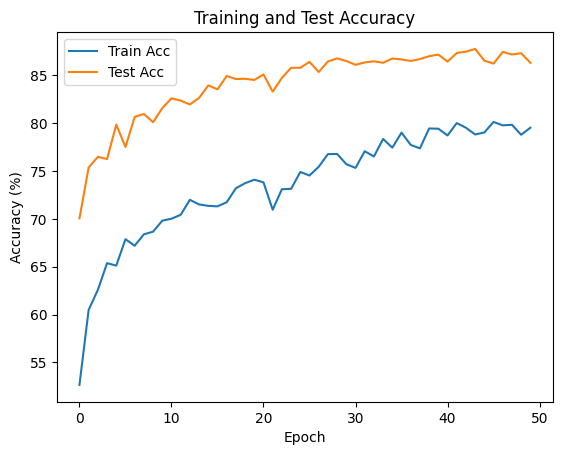

In [10]:
# ### 8. Plot Training Curves
# plt.figure(); plt.plot(train_accs, label='Train Acc'); plt.plot(test_accs, label='Test Acc'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Training and Test Accuracy'); plt.show()
plt.figure(); plt.plot(train_accs, label='Train Acc'); plt.plot(test_accs, label='Test Acc');
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Training and Test Accuracy'); plt.show()


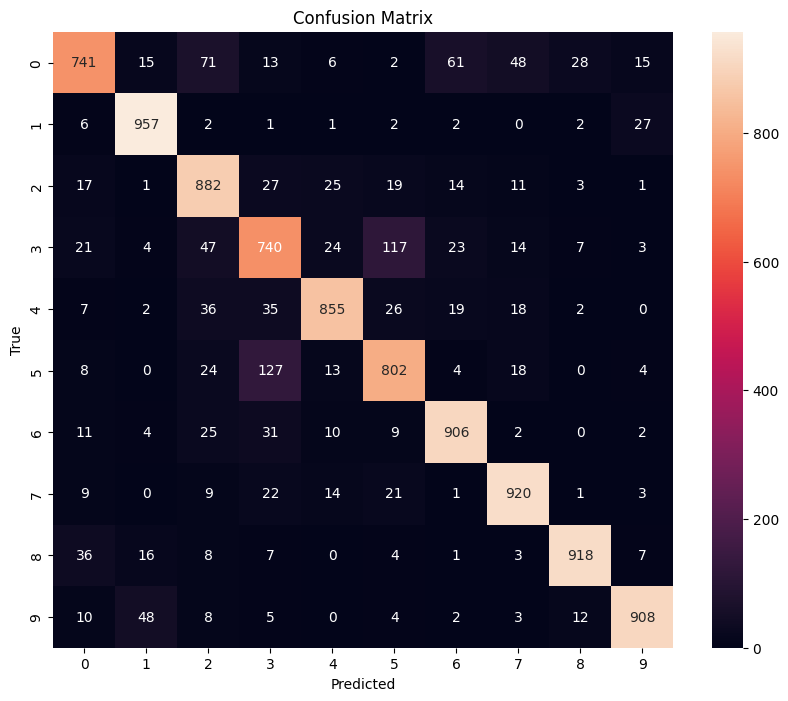

In [11]:
# ### 9. Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()); all_targets.extend(targets.numpy())
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10,8)); sns.heatmap(cm, annot=True, fmt='d');
plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()


In [12]:
# ### 11. Save Model
# os.makedirs('checkpoints', exist_ok=True)
# torch.save(model.state_dict(), 'checkpoints/resnet18_cifar10_improved.pth')
# Save the trained model
torch.save(model.state_dict(), '/kaggle/working/cifar10_resnet18.pth')
print('Model saved to /kaggle/working/cifar10_resnet18.pth')

Model saved to /kaggle/working/cifar10_resnet18.pth


In [13]:
!ls checkpoints

ls: cannot access 'checkpoints': No such file or directory


In [14]:
# ### 12. Inference Demo

# Load the saved model (ensure same architecture)
infer_model = models.resnet18(pretrained=False)
infer_model.fc = nn.Linear(infer_model.fc.in_features, num_classes)
infer_model.load_state_dict(torch.load('/kaggle/working/cifar10_resnet18.pth', map_location=device))
infer_model = infer_model.to(device)
infer_model.eval()

# Function to preprocess and predict a single image
def predict_image(image_path, transform=test_transforms, model=infer_model):
    img = Image.open(image_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        top_prob, top_cls = torch.max(probs, dim=0)
    print(f"Predicted class: {class_names[top_cls]} (prob={top_prob:.4f})")
    return class_names[top_cls], top_prob.item()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
# # Example usage:
# # replace '0002.jpg' with your image file path (ensure 32×32 or larger)
# predict_image('/kaggle/working/0002.jpg')
